# Comparativa de Modelos de Clasificación usando PCA y MCA
## Análisis del Dataset de Estilo de Vida y Salud

---

Este notebook implementa una comparativa exhaustiva de modelos de clasificación utilizando técnicas de reducción de dimensionalidad **PCA (Análisis de Componentes Principales)** y **MCA (Análisis de Correspondencias Múltiples)** en un dataset de estilo de vida y salud.

### Objetivos:
- Aplicar técnicas de selección de características y reducción de dimensionalidad
- Comparar el rendimiento de modelos con diferentes enfoques de preprocesamiento
- Analizar el impacto de PCA en variables numéricas y MCA en variables categóricas
- Evaluar modelos híbridos que combinen ambas técnicas

### Dataset:
**Health Lifestyle Dataset** con información de 100,000 personas incluyendo:
- **Variables numéricas**: age, bmi, blood_pressure, cholesterol, etc.
- **Variables categóricas**: gender, marital_status, diet_type, occupation, etc.
- **Target**: Clasificación binaria (healthy/diseased) - ~70% sanos, ~30% enfermos

---

## 1. Importación de libreria

In [2]:
# Bibliotecas principales
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import os
# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 6)

# Preprocessing y división de datos
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Reducción de dimensionalidad
from sklearn.decomposition import PCA
%pip install mca
import mca  # Para MCA

# Modelos de clasificación
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier

# Métricas de evaluación
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, confusion_matrix,
                           classification_report, roc_curve, auc)

# Utilidades adicionales
import time
from collections import defaultdict
# Kaggle
import kagglehub

In [3]:
path = kagglehub.dataset_download("mahdimashayekhi/disease-risk-from-daily-habits")
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
csv_path = os.path.join(path, csv_files[0])
df = pd.read_csv(csv_path)
df.info()

100%|██████████| 20.8M/20.8M [00:01<00:00, 19.5MB/s]

Extracting files...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 48 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   survey_code               100000 non-null  int64  
 1   age                       100000 non-null  int64  
 2   gender                    100000 non-null  object 
 3   height                    100000 non-null  float64
 4   weight                    100000 non-null  float64
 5   bmi                       100000 non-null  float64
 6   bmi_estimated             100000 non-null  float64
 7   bmi_scaled                100000 non-null  float64
 8   bmi_corrected             100000 non-null  float64
 9   waist_size                100000 non-null  float64
 10  blood_pressure            92331 non-null   float64
 11  heart_rate                85997 non-null   float64
 12  cholesterol               100000 non-null  float64
 13  glucose                   100000 non-null  fl

In [5]:
# Eliminar surveycode
if 'survey_code' in df.columns:
    df.drop(columns=['survey_code'], inplace=True)
# Separar columnas por tipo de dato
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
# Excluir la columna objetivo de ambas listas
if 'target' in numerical_cols:
    numerical_cols.remove('target')
if 'target' in categorical_cols:
    categorical_cols.remove('target')

## 2. Exploratory Data Analysis (EDA)

Realizamos un análisis exploratorio completo para entender la estructura de los datos, distribuciones, correlaciones y relaciones con la variable objetivo.

In [6]:
print(f"Dimensiones: {df.shape}")

Dimensiones: (100000, 47)


In [7]:
print(f"Valores faltantes: {df.isnull().sum().sum()}")

Valores faltantes: 165398


In [8]:
print(f"Tipos de datos:")
print(df.dtypes.value_counts())

Tipos de datos:
float64    24
object     18
int64       5
Name: count, dtype: int64


In [9]:
target_counts = df['target'].value_counts()
target_props = df['target'].value_counts(normalize=True)
for val in target_counts.index:
    print(f"{val}: {target_counts[val]:,} ({target_props[val]:.2%})")

healthy: 70,097 (70.10%)
diseased: 29,903 (29.90%)


In [10]:
print(f"Variables numéricas ({len(numerical_cols)}): {numerical_cols}")
print(f"Variables categóricas ({len(categorical_cols)}): {categorical_cols}")

Variables numéricas (29): ['age', 'height', 'weight', 'bmi', 'bmi_estimated', 'bmi_scaled', 'bmi_corrected', 'waist_size', 'blood_pressure', 'heart_rate', 'cholesterol', 'glucose', 'insulin', 'sleep_hours', 'work_hours', 'physical_activity', 'daily_steps', 'calorie_intake', 'sugar_intake', 'water_intake', 'screen_time', 'stress_level', 'mental_health_score', 'income', 'meals_per_day', 'electrolyte_level', 'gene_marker_flag', 'environmental_risk_score', 'daily_supplement_dosage']
Variables categóricas (17): ['gender', 'sleep_quality', 'alcohol_consumption', 'smoking_level', 'mental_health_support', 'education_level', 'job_type', 'occupation', 'diet_type', 'exercise_type', 'device_usage', 'healthcare_access', 'insurance', 'sunlight_exposure', 'caffeine_intake', 'family_history', 'pet_owner']


In [11]:
df.describe().round(2)

,age,height,weight,bmi,bmi_estimated,bmi_scaled,bmi_corrected,waist_size,blood_pressure,heart_rate,...,water_intake,screen_time,stress_level,mental_health_score,income,meals_per_day,electrolyte_level,gene_marker_flag,environmental_risk_score,daily_supplement_dosage
count,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,92331.00,85997.00,...,100000.00,100000.00,100000.00,100000.00,91530.00,100000.00,100000.0,89526.0,100000.0,100000.00
mean,48.53,170.02,70.06,24.49,24.49,73.48,24.49,84.93,119.98,74.97,...,2.01,6.02,4.99,5.00,4038.13,3.00,0.0,1.0,5.5,0.02
std,17.89,9.98,14.69,5.95,5.95,17.85,5.95,12.04,15.02,9.94,...,0.69,2.93,3.15,3.16,1930.03,1.41,0.0,0.0,0.0,5.76
min,18.00,140.00,40.00,9.99,9.99,29.97,9.89,34.09,59.13,34.75,...,0.50,0.00,0.00,0.00,500.00,1.00,0.0,1.0,5.5,-10.00
25%,33.00,163.31,59.86,20.27,20.27,60.81,20.27,76.80,109.81,68.28,...,1.53,3.97,2.00,2.00,2665.40,2.00,0.0,1.0,5.5,-4.98
50%,48.00,170.02,69.92,24.16,24.16,72.47,24.15,84.96,119.95,75.05,...,2.00,5.99,5.00,5.00,4004.60,3.00,0.0,1.0,5.5,0.02
75%,64.00,176.73,80.03,28.26,28.26,84.78,28.25,93.02,130.12,81.69,...,2.47,8.02,8.00,8.00,5360.01,4.00,0.0,1.0,5.5,5.01
max,79.00,210.00,139.25,59.23,59.23,177.70,59.14,133.15,184.44,114.14,...,5.00,16.00,10.00,10.00,12029.41,5.00,0.0,1.0,5.5,10.00


## 3. Preprocesamiento de datos

Preparamos los datos para el modelado, incluyendo la codificación de variables categóricas, estandarización de variables numéricas y división en conjuntos de entrenamiento y prueba.

In [12]:
# Separar X e y
X = df.drop('target', axis=1)
y = df['target']

# Imputación y escalado para variables numéricas, estrategia de media
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Imputación y codificación para variables categóricas
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# ColumnTransformer para aplicar los pipelines
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_cols)
])

# Aplicar preprocesamiento
X_preprocessed = preprocessor.fit_transform(X)
print(f"X_preprocessed shape: {X_preprocessed.shape}")

X_preprocessed shape: (100000, 82)


## 4. PCA

Aplicamos Análisis de Componentes Principales (PCA) a las variables numéricas para reducir la dimensionalidad manteniendo el 70% de la varianza explicada.

Componentes PCA: 15


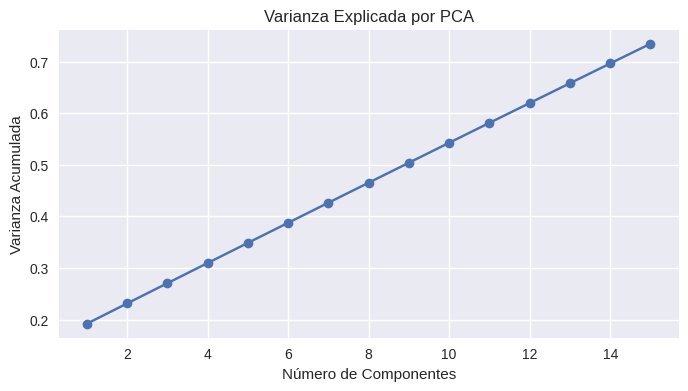

In [13]:
# PCA sobre variables numéricas de X
X_num = X[numerical_cols]
X_num_imputed = SimpleImputer(strategy='mean').fit_transform(X_num)
X_num_scaled = StandardScaler().fit_transform(X_num_imputed)

pca = PCA(n_components=0.7, random_state=123)
X_pca = pca.fit_transform(X_num_scaled)
print(f"Componentes PCA: {X_pca.shape[1]}")

plt.figure(figsize=(8,4))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada')
plt.title('Varianza Explicada por PCA')
plt.grid(True)
plt.show()

## 5. MCA

Aplicamos Análisis de Correspondencias Múltiples (MCA) a las variables categóricas para reducir la dimensionalidad y capturar patrones en los datos categóricos.

In [17]:
# MCA sobre variables categóricas de X
X_cat = X[categorical_cols]
X_cat_imputed = SimpleImputer(strategy='most_frequent').fit_transform(X_cat)
X_cat_df = pd.DataFrame(X_cat_imputed, columns=categorical_cols)
X_cat_dummies = pd.get_dummies(X_cat_df, drop_first=False)
mca_model = mca.MCA(X_cat_dummies, ncols=len(X_cat_dummies.columns))

In [33]:
X_mca = mca_model.fs_r_sup(X_cat_dummies)

In [34]:
# Valores singulares y autovalores
sv = mca_model.s
eigvals = sv ** 2
explained_var = eigvals / eigvals.sum()
cum_explained_var = np.cumsum(explained_var)
# Número de componentes para >=70% varianza explicada
n_components_70 = np.argmax(cum_explained_var >= 0.7) + 1
print(f"Componentes MCA para >=70% varianza explicada: {n_components_70}")
X_mca_70 = X_mca[:, :n_components_70]
print(f"Shape de X_mca_70: {X_mca_70.shape}")

Componentes MCA para >=70% varianza explicada: 25
Shape de X_mca_70: (100000, 25)


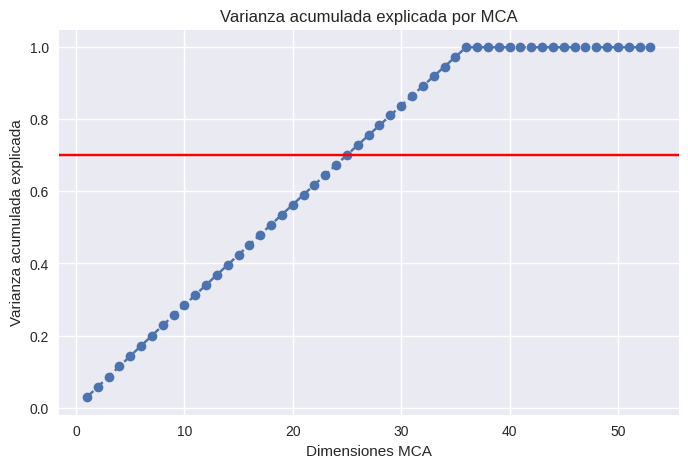

In [31]:
# Graficar varianza acumulada
plt.figure(figsize=(8,5))
plt.plot(range(1, len(cum_explained_var)+1), cum_explained_var, marker='o', linestyle='--')
plt.axhline(y=0.7, color='r', linestyle='-')
plt.xlabel('Dimensiones MCA')
plt.ylabel('Varianza acumulada explicada')
plt.title('Varianza acumulada explicada por MCA')
plt.grid(True)
plt.show()

## 5. Prueba rápida de modelos

Aplicamos una prueba rápida de modelos con solo PCA y con PCA/MCA

In [ ]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=123),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=123),
    'SVM': SVC(kernel='rbf', probability=True, random_state=123),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=123)
}

results = {'PCA': {}, 'MCA': {}}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# Evaluar modelos con PCA
print("\nResultados con PCA:")
for name, model in models.items():
    scores = cross_val_score(model, X_pca, y, cv=cv, scoring='accuracy')
    results['PCA'][name] = scores
    print(f"{name}: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

# Evaluar modelos con MCA
print("\nResultados con MCA")
for name, model in models.items():
    scores = cross_val_score(model, X_mca_70, y, cv=cv, scoring='accuracy')
    results['MCA'][name] = scores
    print(f"{name}: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

# Combinar componentes PCA y MCA
X_combined = np.concatenate([X_pca, X_mca_70], axis=1)

print("\nResultados con PCA+MCA combinados:")
for name, model in models.items():
    scores = cross_val_score(model, X_combined, y, cv=cv, scoring='accuracy')
    print(f"{name}: {np.mean(scores):.3f} ± {np.std(scores):.3f}")


Resultados con PCA:
LogisticRegression: 0.701 ± 0.000
RandomForest: 0.700 ± 0.000
